# Analysis of CrowdFlower job #761593: sentence-level CID verification task with NER mistake choice for 200 development set abstracts

Tong Shu Li<br>
Created on Tuesday 2015-08-11<br>
Last updated 2015-08-13

A fourth choice, NER mistake, was added to the response form for the sentence-level CID verification task for BioCreative V. Here we analyze the results from this run.

Job Settings:

Parameter | Value
--- | ---
Job ID | #761593
Rows per page | 5
Judgements per row | 5
Payment per page | 10 cents USD
Payment per row | 2 cents USD
Contributor level | 2
Minimum time per page | 20 seconds
Minimum accuracy threshold | 70%
Number of test questions | 54
Date of launch | 11:36 am 2015-08-10
Date of finish | Job reached 85.9% completion at 11:30 am 2015-08-11 and was stopped
Total cost before bonuses | \$212.76 USD
Total cost after bonuses | $212.76 USD

---

In [28]:
from __future__ import division
from collections import Counter
from collections import defaultdict
from IPython.display import Image
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pycountry

In [2]:
matplotlib inline

In [3]:
WORK_UNITS_PER_PAGE = 5

In [4]:
from src.filter_data import filter_data
from src.data_model import parse_input
from src.data_model import Relation
from src.get_AUC_value import get_AUC_value
from src.F_score import *
from src.aggregate_results import *

In [5]:
def convert_time(text):
    """
    Given the time in CrowdFlower's output format,
    convert it to a Python datetime object.
    CrowdFlower time stamps are in UTC.
    
    CrowdFlower timestamps have the following format:
    
    month/day/year hour:minute:second
    
    Example:
    
    8/2/2015 00:26:24
    """
    return dt.datetime.strptime(text, "%m/%d/%Y %H:%M:%S")

def time_elapsed(start, stop):
    """
    Given two Python datetime objects, determines the number
    of seconds between those two times.
    """
    seconds = int((stop - start).total_seconds())
    assert seconds >= 0
    return seconds

def determine_time_taken(dataframe):
    """
    Given a dataframe with the responses from one worker,
    determines the time taken for one page of work.
    """
    def time_taken_wrapper(row):
        return time_elapsed(row[0], row[1])
    
    if dataframe.empty:
        return pd.Series()
    
    time_taken = dataframe[["_started_at", "_created_at"]].apply(time_taken_wrapper, axis = 1)
    return time_taken

def time_stats(time_series):
    """
    Given the time taken for each individual work unit,
    determines some stats.
    """
    return (time_series.min(), time_series.median(), time_series.max())

def get_country_name(code):
    if isinstance(code, str):
        return pycountry.countries.get(alpha3 = code).name.split(",")[0]
    
    # code is missing (NaN)
    return "unknown"

---

### Read the results:

In [6]:
settings = {
    "loc": "data/crowdflower/results",
    "fname": "job_761593_full_with_untrusted.csv",
    "data_subset": "all",
    "min_accuracy": 0.0,
    "max_accuracy": 1.0
}

raw_data = filter_data(settings)

In [7]:
raw_data.shape

(11355, 31)

In [8]:
len(raw_data["_worker_id"].unique())

493

### Conver timestamps to datetime objects:

In [9]:
raw_data.loc[:, "_created_at"] = raw_data.loc[:, "_created_at"].map(convert_time)
raw_data.loc[:, "_started_at"] = raw_data.loc[:, "_started_at"].map(convert_time)

### Build worker profiles:

In [10]:
def build_worker_profiles(raw_data):
    """
    Build a profile for every worker that tried the task.
    """
    res = defaultdict(list)
    
    metadata = ["_trust", "_ip", "_channel"]
    ans_choices = ["yes_direct", "yes_indirect", "no_relation", "ner_mistake"]
    
    for worker_id, group in raw_data.groupby("_worker_id"):
        test_resp = group.query("_golden")
        work_resp = group.query("~_golden")
        
        res["worker_id"].append(worker_id)
        res["test_ques_seen"].append(len(test_resp["uniq_id"].unique()))
        res["work_units_seen"].append(len(work_resp["uniq_id"].unique()))
        
        res["country"].append(get_country_name(test_resp["_country"].iloc[0]))
        
        for metadata_col in metadata:
            res[metadata_col.lstrip("_")].append(test_resp[metadata_col].iloc[0])
            
        for work_type, resp_data in zip(["test", "work"], [test_resp, work_resp]):
            time_series = determine_time_taken(resp_data) # time per page
            time_series /= WORK_UNITS_PER_PAGE # time per work unit
            
            stats = time_stats(time_series)
            for i, name in enumerate(["min", "median", "max"]):
                res["{0}_{1}_time_per_unit".format(work_type, name)].append(stats[i])
                
            # look at the response distributions
            for ans_choice in ans_choices:
                temp = resp_data.query("verify_relationship == '{0}'".format(ans_choice))
                res["{0}_{1}".format(work_type, ans_choice)].append(len(temp["uniq_id"].unique()))
        
    return pd.DataFrame(res)

In [11]:
worker_profiles = build_worker_profiles(raw_data)

In [12]:
worker_profiles.head()

,channel,country,ip,test_max_time_per_unit,test_median_time_per_unit,test_min_time_per_unit,test_ner_mistake,test_no_relation,test_ques_seen,test_yes_direct,...,trust,work_max_time_per_unit,work_median_time_per_unit,work_min_time_per_unit,work_ner_mistake,work_no_relation,work_units_seen,work_yes_direct,work_yes_indirect,worker_id
0,clixsense,India,203.109.99.21,28.8,28.8,28.8,0,2,5,3,...,0.4000,NaN,NaN,NaN,0,0,0,0,0,6330164
1,clixsense,Russian Federation,88.147.153.49,88.2,88.2,88.2,0,3,5,2,...,0.8000,NaN,NaN,NaN,0,0,0,0,0,6333917
2,clixsense,Romania,86.120.72.205,44.4,9.5,5.8,3,14,34,13,...,0.7941,34.8,9,5.8,2,63,116,48,3,6335233
3,clixsense,Serbia,178.222.134.61,70.8,70.8,70.8,1,3,5,1,...,0.2000,NaN,NaN,NaN,0,0,0,0,0,6338920
4,clixsense,Romania,86.34.206.57,71.4,71.4,71.4,1,2,5,1,...,0.4000,NaN,NaN,NaN,0,0,0,0,0,6343537


### Worker trust over time:

In [13]:
def trust_over_time(dataframe):
    res = defaultdict(list)

    list_size = 0
    for worker_id, resp in dataframe.groupby("_worker_id"):
        cum_seen = 0
        cum_missed = 0
        for fin_time, page in resp.groupby("_created_at"):
            seen = page["_golden"].sum()
            missed = page["_missed"].sum()
            
            if np.isnan(missed):
                missed = 0
                
            cum_seen += seen
            cum_missed += missed
            res[worker_id].append(1 - cum_missed / cum_seen)
            
        list_size = max(list_size, len(res[worker_id]))
        
    temp = dict()
    for worker_id, values in res.items():
        temp[worker_id] = values + [np.nan] * (list_size - len(values))
        
    return pd.DataFrame(temp)

In [14]:
timeres = trust_over_time(raw_data)

In [15]:
timeres.head()

,6330164,6333917,6335233,6338920,6343537,6344072,6360932,6508242,6572540,6602283,...,33732804,33735843,33738650,33746717,33747289,33784982,33803732,33935996,33973110,33982690
0,0.4,0.8,1.000000,0.2,0.4,0.6,0.4,0.2,0,0.800000,...,0.6,0.6,0.4,0.6,0.4,0.6,1,0.2,0.4,0.6
1,NaN,NaN,0.833333,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
2,NaN,NaN,0.857143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
3,NaN,NaN,0.875000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
4,NaN,NaN,0.888889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN


### When do people fail out of the job?

In [16]:
THRESHOLD = 0.7

def failed(series):
    series = series.dropna()
    return len(series) > 1 and series.iat[0] > THRESHOLD and series.iat[-1] < THRESHOLD

failures = timeres.apply(failed, axis = 0)

In [17]:
fail_ids = [w for w in failures.index if failures[w]]

In [18]:
failures = timeres[fail_ids]

In [19]:
failures.head()

,6602283,7117281,9082954,11011130,11014428,11081436,11302447,11975072,12767067,12951494,...,32520821,32791987,33090859,33128050,33243541,33341569,33379739,33387828,33571357,33690860
0,0.800000,0.800000,0.800000,0.800000,0.800000,0.800000,1.000000,1.000000,0.800000,0.800000,...,0.800000,0.800000,0.800000,0.800000,0.800000,1.000000,1.000000,0.800000,1.000000,0.800000
1,0.666667,0.666667,0.666667,0.666667,0.666667,0.833333,0.833333,0.833333,0.666667,0.666667,...,0.666667,0.666667,0.666667,0.833333,0.833333,1.000000,0.833333,0.666667,0.833333,0.666667
2,NaN,NaN,NaN,NaN,NaN,0.714286,0.857143,0.857143,NaN,NaN,...,NaN,NaN,NaN,0.857143,0.857143,0.857143,0.714286,NaN,0.857143,NaN
3,NaN,NaN,NaN,NaN,NaN,0.750000,0.875000,0.875000,NaN,NaN,...,NaN,NaN,NaN,0.875000,0.875000,0.750000,0.750000,NaN,0.750000,NaN
4,NaN,NaN,NaN,NaN,NaN,0.777778,0.777778,0.777778,NaN,NaN,...,NaN,NaN,NaN,0.888889,0.777778,0.777778,0.777778,NaN,0.666667,NaN


In [20]:
def plot_trust(dataframe):
    graph = dataframe.plot(legend = False, figsize = (10, 5))

    graph.set_ylim((0.5, 1.05))

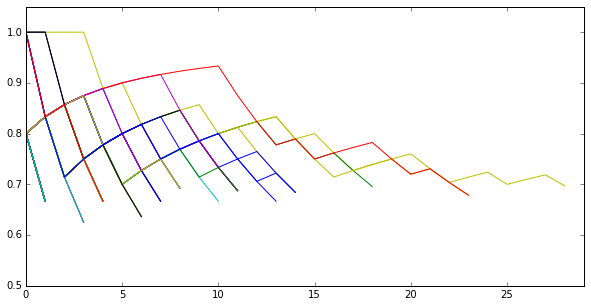

In [21]:
plot_trust(failures)

In [22]:
time_to_fail = failures.apply(lambda x: len(x.dropna()), axis = 0)

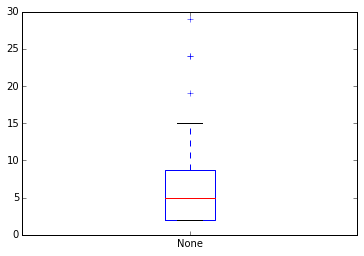

In [23]:
time_to_fail.plot(kind = "box")

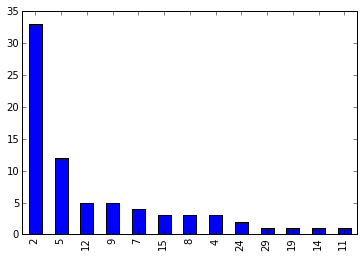

In [24]:
time_to_fail.value_counts().plot(kind = "bar")

From these plots we see that the vast majority of people who initially make it past the quiz fail on the very next work unit. If people have not failed by the 10th work unit, then they are not very likely to fail at all. There seems to have been one person who failed just one page before he was finished with all the work, which is unfortunate since it costs a lot and we lose a lot of judgements.

### Answer distribution over time:

In [29]:
def resp_over_time(dataframe):
    testres = []
    workres = []
    time_taken = []
    
    # for one worker only
    for fin_time, page in dataframe.groupby("_created_at"):
        test_dist = page.query("_golden")["verify_relationship"].value_counts(normalize = True)
        work_dist = page.query("~_golden")["verify_relationship"].value_counts(normalize = True)
        
        start_time = page["_started_at"].iloc[0].to_datetime()
        stop_time = page["_created_at"].iloc[0].to_datetime()
        
        time_used = int((stop_time - start_time).total_seconds())
        
        testres.append(test_dist)
        workres.append(work_dist)
        time_taken.append(time_used)
        
    testres = pd.DataFrame(testres).fillna(0)
    workres = pd.DataFrame(workres).fillna(0)
    
    return (pd.Series(time_taken), testres, workres)

def plot_worker_resp(job_id, worker_id, dataframe):
    data = dataframe.query("_worker_id == {0}".format(worker_id))
    
    time_taken, testres, workres = resp_over_time(data)
    
    trust_time = timeres[worker_id].dropna()
    
    
    fig, axs = plt.subplots(4, 1, figsize = (10, 19))
    
    fig.suptitle("Profile for worker {0} for job {1}".format(worker_id, job_id, fontsize = 20))

    for i in range(3):
        axs[i].set_ylim((0, 1.05))
    
    axs[0].set_xlabel("Pages of work in ascending time order")
    
    axs[0].set_ylabel("Cumulative trust score")
    axs[1].set_ylabel("% of responses")
    axs[2].set_ylabel("% of responses")
    axs[3].set_ylabel("Time used for one page of work in seconds")
    
    trust_time.plot(ax = axs[0],
                   title = "Cumulative trust score over time")
    
    testres.plot(ax = axs[1],
                title = "Test question distribution")
    workres.plot(ax = axs[2],
                title = "Work unit distribution")
    
    time_taken.plot(ax = axs[3],
                   title = "Time spent on each page of work in seconds")
    
    plt.savefig("data/worker_profiles/job_{0}/worker_{1}_profile.png".format(job_id, worker_id))
    plt.close(fig)
                     

In [30]:
job_id = 761593

In [32]:
plot_worker_resp(job_id, 11081436, raw_data)

In [33]:
for worker_id in worker_profiles.query("work_units_seen > 0")["worker_id"].unique():
    plot_worker_resp(job_id, worker_id, raw_data)

---

In [37]:
def plot_by_group(column, dataframe, title):
    countries = dataframe[column].value_counts()
    
    graph = countries.plot(kind = "barh", figsize = (10, 10),
                           title = title,
                           fontsize = 12)

    graph.set_xlabel("Number of workers")

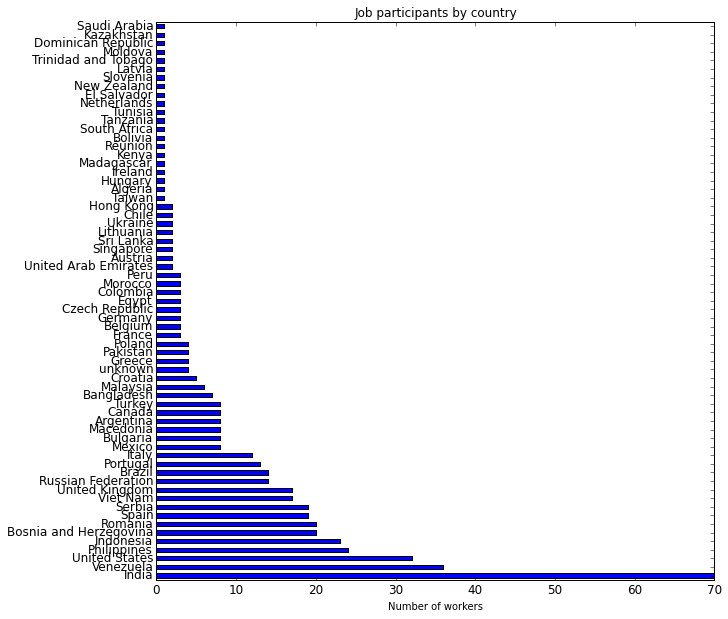

In [38]:
plot_by_group("country", worker_profiles, "Job participants by country")

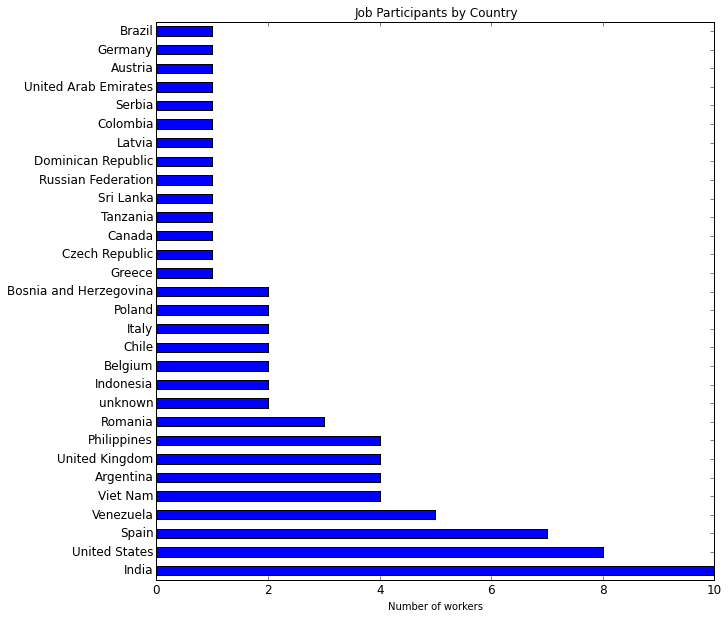

In [39]:
# workers who passed only
temp = worker_profiles.query("trust >= 0.7")
plot_by_group("country", temp, "Job Participants by Country")

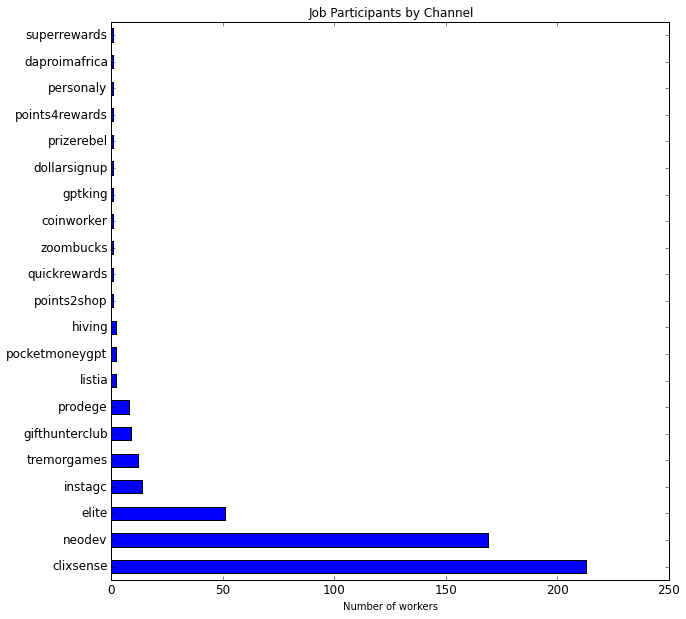

In [40]:
plot_by_group("channel", worker_profiles, "Job Participants by Channel")

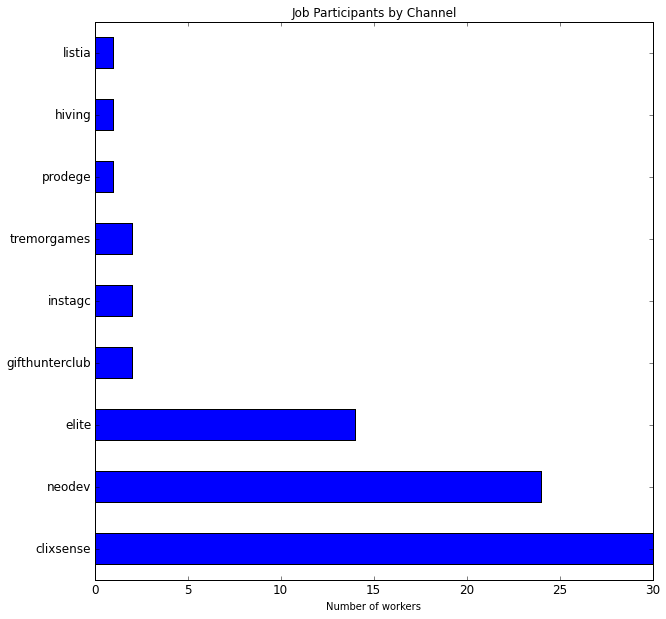

In [41]:
# workers who passed only
temp = worker_profiles.query("trust >= 0.7")
plot_by_group("channel", temp, "Job Participants by Channel")

In [42]:
def plot_work_speed(column, dataframe, title):
    """
    Plot speed of work.
    """
    graph = dataframe.boxplot("work_median_time_per_unit", by = column, figsize = (10, 10),
                     rot = 75, fontsize = 12)

    graph.set_ylabel("Median work unit response time in seconds")
    graph.set_title(title)

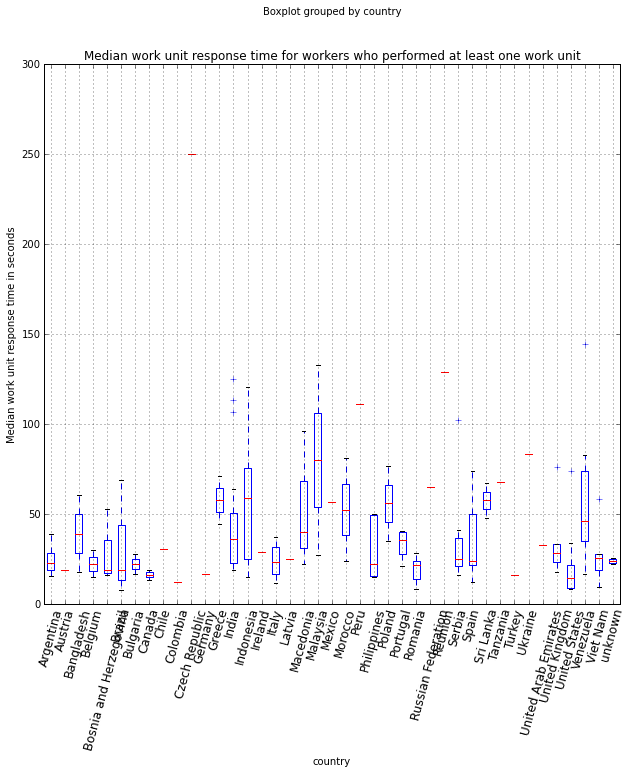

In [43]:
data = worker_profiles.query("work_units_seen > 0")
plot_work_speed("country", data, "Median work unit response time for workers who performed at least one work unit")

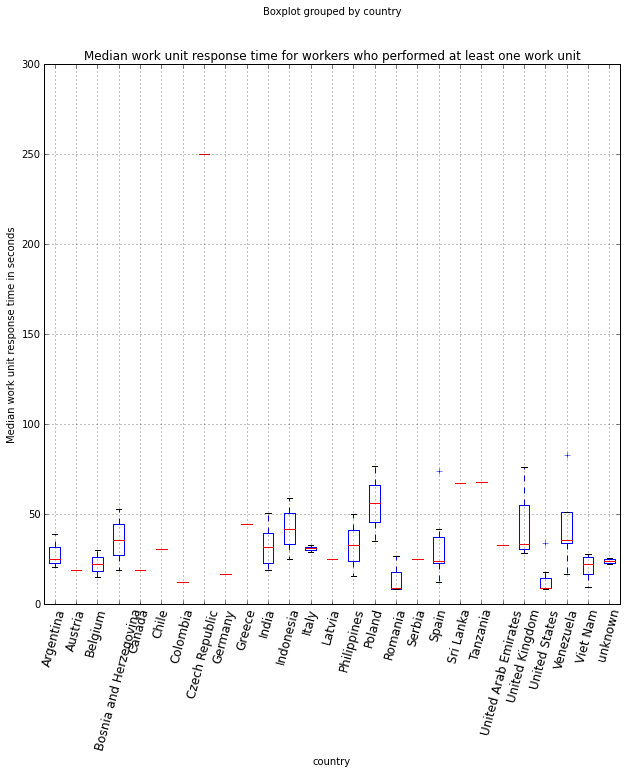

In [44]:
data = worker_profiles.query("work_units_seen > 0 and trust >= 0.7")
plot_work_speed("country", data, "Median work unit response time for workers who performed at least one work unit")

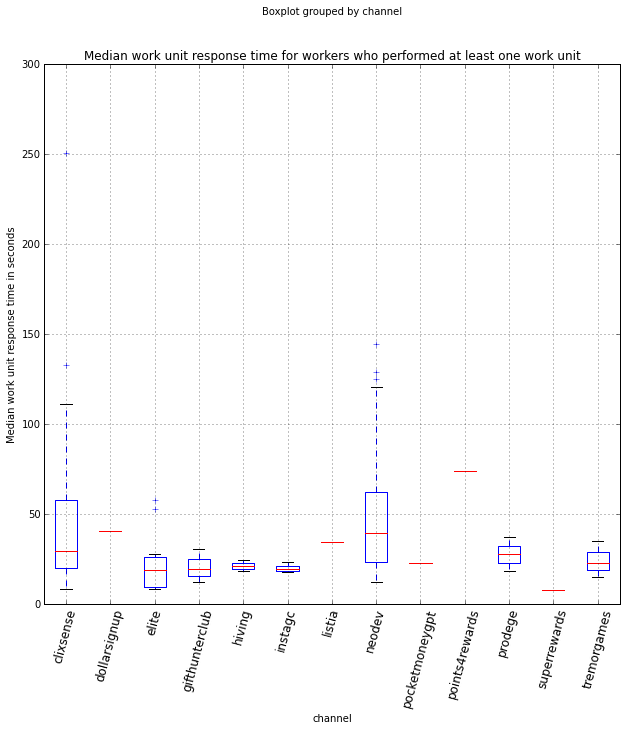

In [45]:
data = worker_profiles.query("work_units_seen > 0")
plot_work_speed("channel", data, "Median work unit response time for workers who performed at least one work unit")

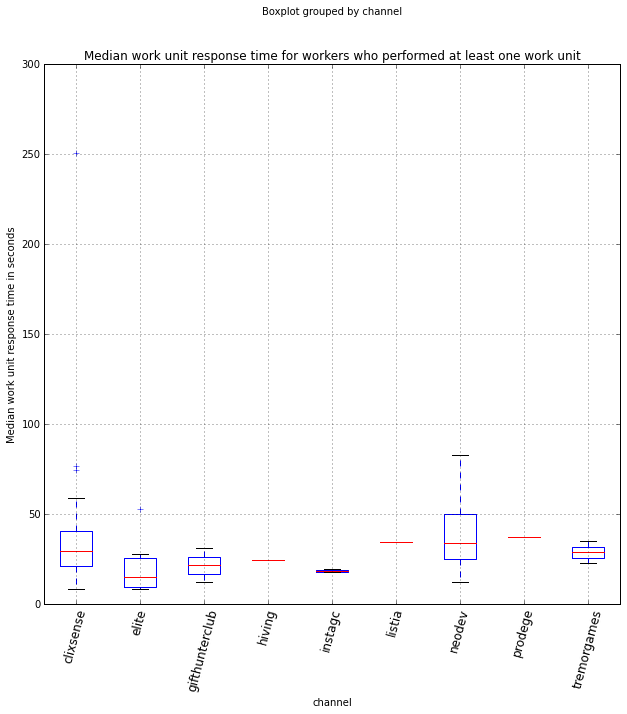

In [46]:
data = worker_profiles.query("work_units_seen > 0 and trust >= 0.7")
plot_work_speed("channel", data, "Median work unit response time for workers who performed at least one work unit")